In [147]:
import numpy as np
import os
import matplotlib.pyplot as plt
from rich import print
import pathlib
from pathlib import Path

import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [148]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [149]:
instruction_data = Path('data') / Path('mini_speech_commands_extracted') / Path('mini_speech_commands')

assert instruction_data.exists(), 'path does not exist'

In [150]:
commands = np.array(tf.io.gfile.listdir(str(instruction_data)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'silence' 'stop' 'up' 'yes']

In [189]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=instruction_data,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8796 files belonging to 9 classes.
Using 7037 files for training.
Using 1759 files for validation.


label names: ['down' 'go' 'left' 'no' 'right' 'silence' 'stop' 'up' 'yes']

In [158]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [159]:
#This dataset only contains single channel audio, so use the tf.squeeze function to drop the extra axis:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [160]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

train_ds.element_spec

(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [161]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)

(64,)

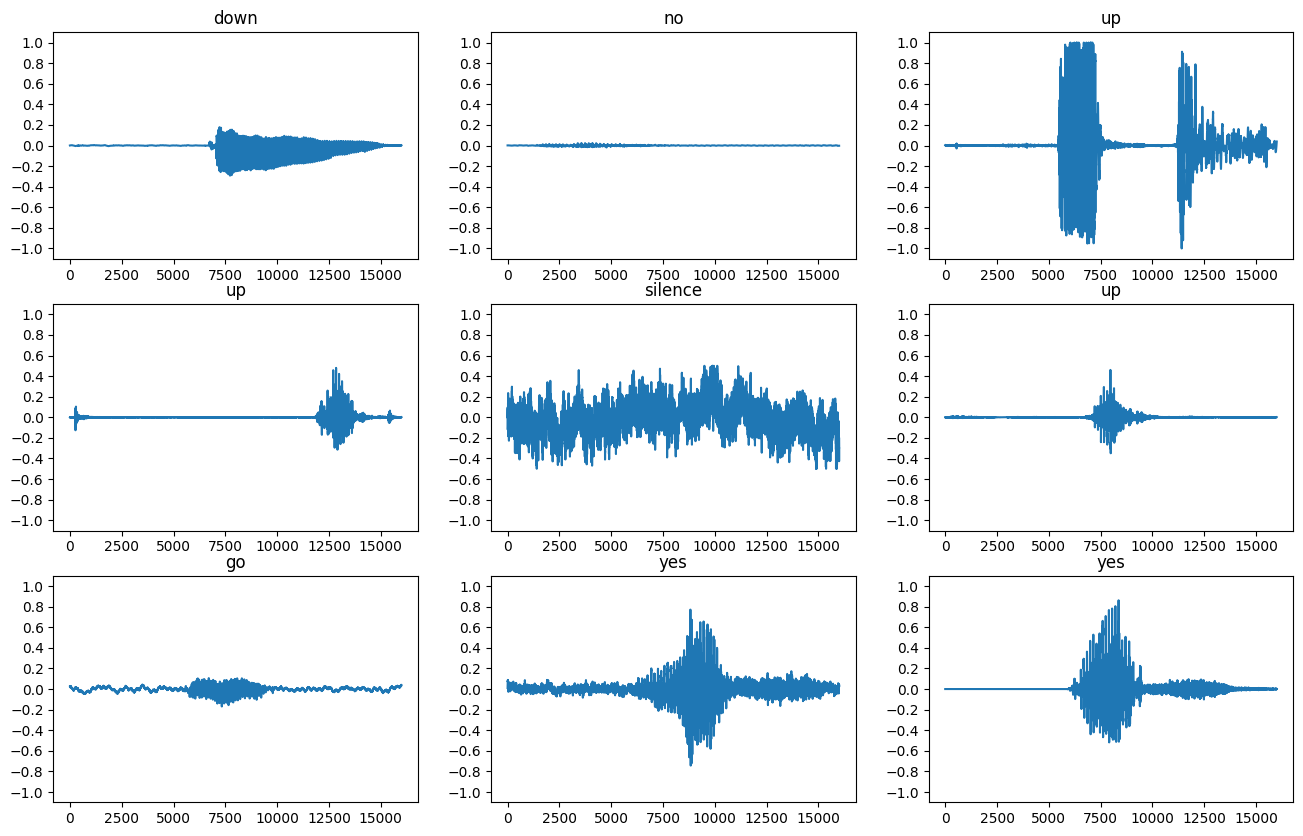

In [165]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i+20]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i+20]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [166]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [167]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: left

Waveform shape: (16000,)

Spectrogram shape: (124, 129, 1)

Audio playback

Label: down

Waveform shape: (16000,)

Spectrogram shape: (124, 129, 1)

Audio playback

Label: go

Waveform shape: (16000,)

Spectrogram shape: (124, 129, 1)

Audio playback

In [86]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

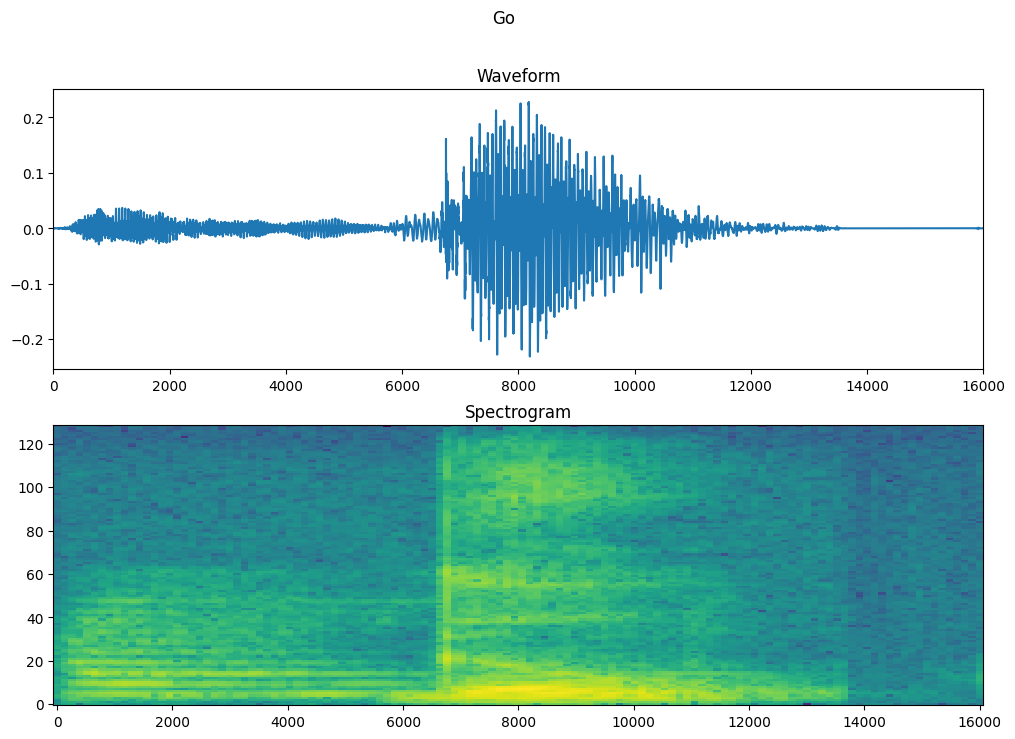

In [168]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [169]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [170]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [171]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

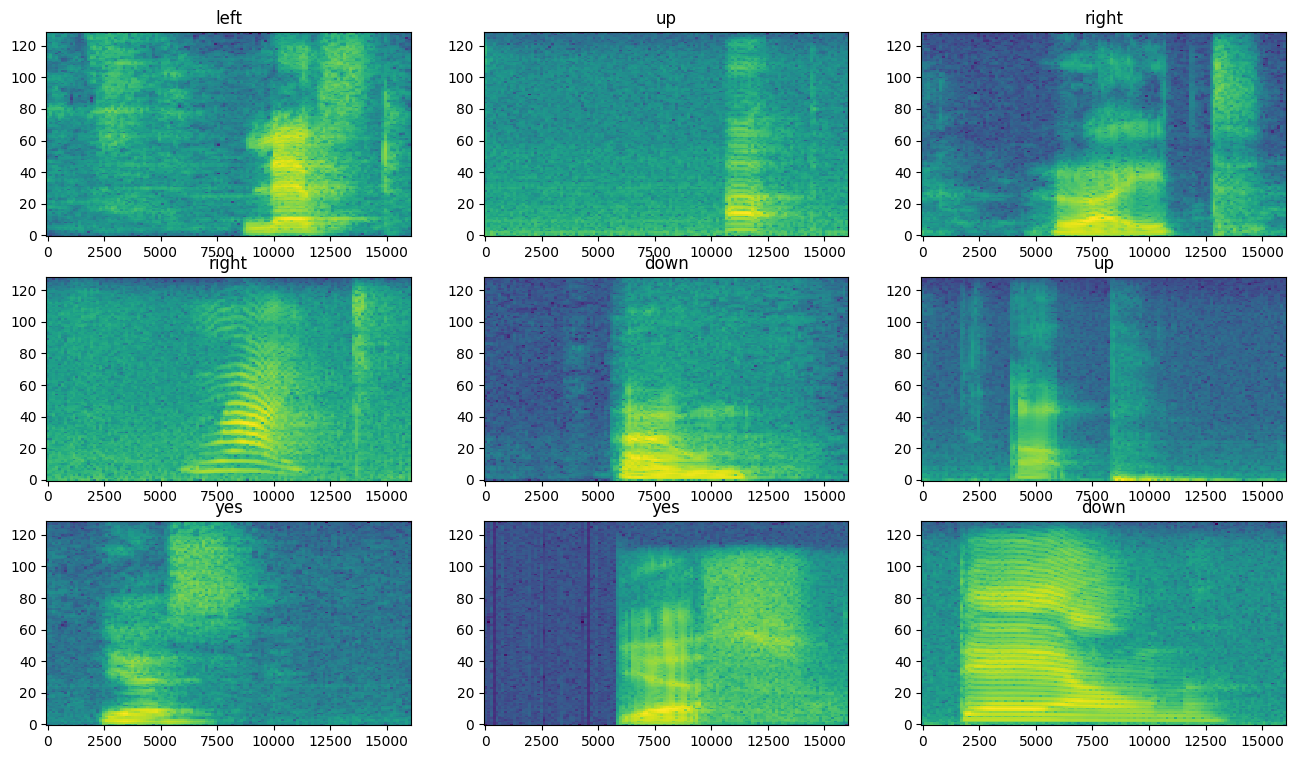

In [172]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [173]:
##Add Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [178]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)


# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(196, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_6 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_9 (Normalization)      │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 196)                 │       2,458,820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 196)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 9)                   │           1,773 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,479,412 (9.46 MB)

 Trainable params: 2,479,409 (9.46 MB)

 Non-trainable params: 3 (16.00 B)

In [179]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [180]:
EPOCHS = 10

history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.4304 - loss: 1.6401 - val_accuracy: 0.5910 - val_loss: 1.2232
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.6459 - loss: 1.0583 - val_accuracy: 0.7207 - val_loss: 0.8941
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.7294 - loss: 0.7835 - val_accuracy: 0.7671 - val_loss: 0.7643
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.7775 - loss: 0.6397 - val_accuracy: 0.7868 - val_loss: 0.6568
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8126 - loss: 0.5469 - val_accuracy: 0.7961 - val_loss: 0.6234
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8414 - loss: 0.4629 - val_accuracy: 0.8042 - val_loss: 0.6280
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8570 - loss: 0.4209 - val_accuracy: 0.8250 - val_loss: 0.5681
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8722 - loss: 0.3687 - val_accu

Text(0, 0.5, 'Accuracy [%]')

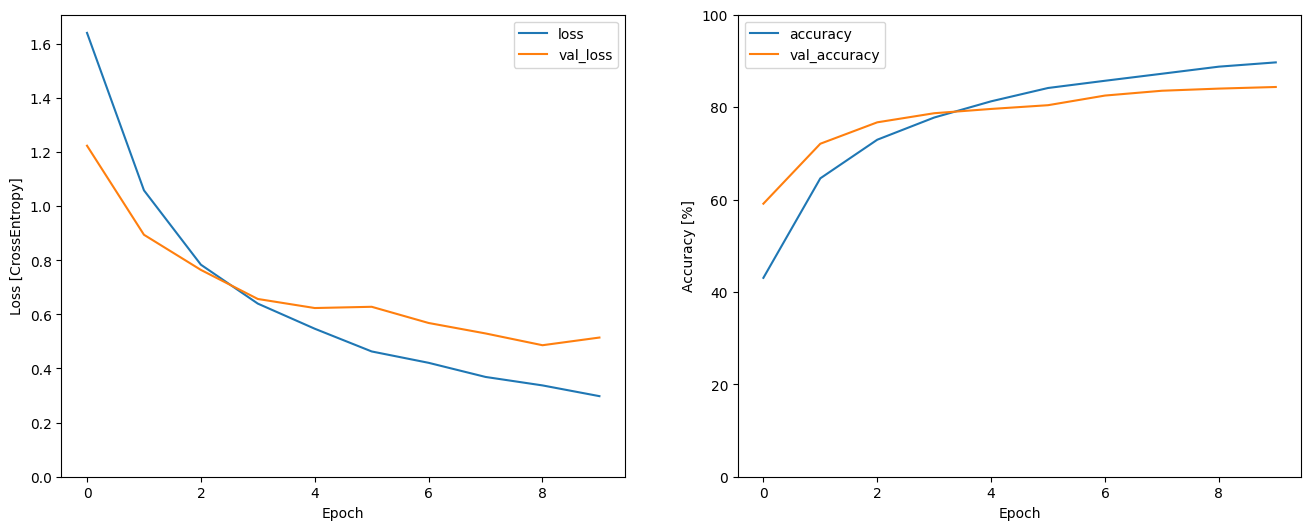

In [181]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [182]:
model.evaluate(test_spectrogram_ds, return_dict=True)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8449 - loss: 0.4699


{'accuracy': 0.8448660969734192, 'loss': 0.46992090344429016}

In [183]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


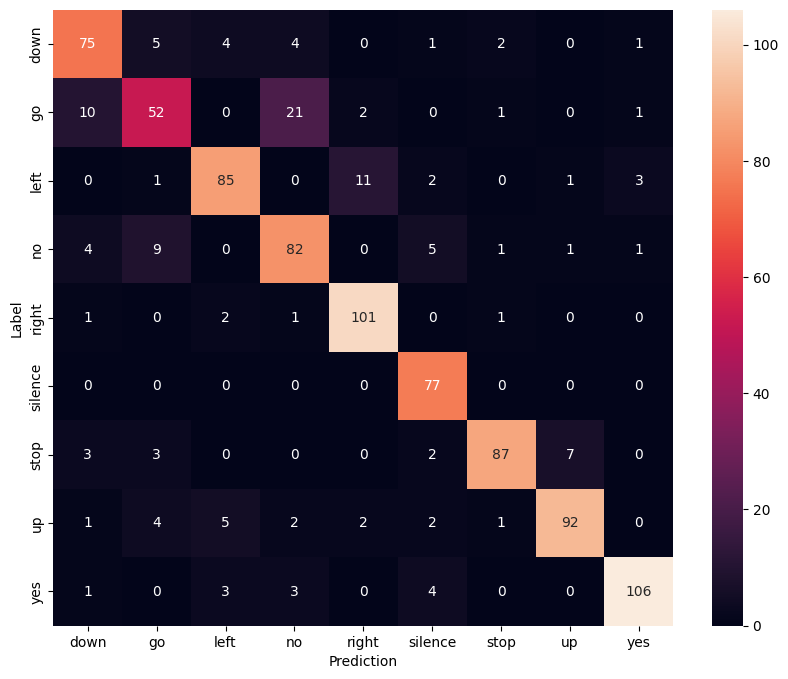

In [184]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

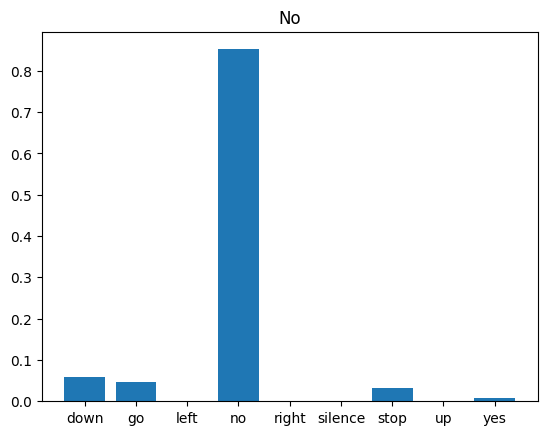

In [185]:
#verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?
x = instruction_data/'no/1c6e5447_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
plt.bar(label_names, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [186]:
MODEL_PATH = "sound_instructions.keras"
model.save(MODEL_PATH)

In [190]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # You could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If a string is passed, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]
    
    x = get_spectrogram(x)  
    result = self.model(x, training=False)
    
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [191]:
export = ExportModel(model)
result = export(tf.constant(str(instruction_data/'no/01bb6a2a_nohash_0.wav')))
result

{'predictions': <tf.Tensor: shape=(1, 9), dtype=float32, numpy=
 array([[ 0.37602824,  3.5005164 , -0.9892025 ,  5.550158  , -2.6359508 ,
         -3.3601017 , -3.0745406 , -2.2837577 , -1.3228631 ]],
       dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

In [192]:
imported = tf.keras.models.load_model(model_path)
exported_model = ExportModel(imported)
result = exported_model(waveform[tf.newaxis, :])
result

{'predictions': <tf.Tensor: shape=(1, 9), dtype=float32, numpy=
 array([[ 2.0344934 ,  1.7922477 , -2.2830749 ,  4.713719  , -6.7359257 ,
         -4.346594  ,  1.4642049 , -2.4974887 ,  0.16921762]],
       dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

In [193]:
class_name = result['class_names'].numpy()[0].decode('utf-8')

print(class_name)

no

In [ ]:
# from src.AudioMutations import AudioMutations
# import random
# from pathlib import Path 
# alarms_path = Path("Alarms")
# boosted_path = Path("DataMutated") / Path("Boosted")
# mutator = AudioMutations()
# mutated_ds_size = 10
# clip_list = os.listdir(alarms_path)
# clip_list = [os.path.join(alarms_path, i) for i in clip_list if i.endswith(".wav")]

# if not boosted_path.exists():
#     boosted_path.mkdir()

# for i in range(mutated_ds_size):
#     index = i % len(clip_list)
#     clip = clip_list[index]
#     boost_factor = round(random.uniform(1.0, 4.0),2)
#     output_filename = f'alarm{index}_{i}_x{boost_factor}.wav'
    
#     output_path = os.path.join(boosted_path, output_filename)
#     mutator.change_volume(clip, boost_factor, output_path)


# shifted_path = Path("DataMutated") / Path("Shifted")

# for i in range(mutated_ds_size):
#     index = i % len(clip_list)
#     clip = clip_list[index]
#     output_filename = f'alarm{index}_{i}.wav'
    
#     output_path = os.path.join(shifted_path, output_filename)
#     mutator.shift_time(file_path=clip, output_path=output_path)


# pitched_path = Path("DataMutated") / Path("Pitched")

# for i in range(mutated_ds_size):
#     index = i % len(clip_list)
#     clip = clip_list[index]
#     pitch_steps = round(random.uniform(-0.2,0.2),3)
#     output_filename = f'alarm{index}_{i}_steps{pitch_steps}.wav'
    
#     output_path = os.path.join(pitched_path, output_filename)
#     mutator.pitch_shift(file_path=clip, n_steps=pitch_steps, output_path=output_path)

# white_noise_path = Path("DataMutated") / Path("WhiteNoised")

# for i in range(mutated_ds_size):
#     index = i % len(clip_list)
#     clip = clip_list[index]
#     noise_factor = round(random.uniform(0.002,0.02),3)
#     output_filename = f'alarm{index}_{i}x{noise_factor}.wav'
    
#     output_path = os.path.join(white_noise_path, output_filename)
#     mutator.add_white_noise(file_path=clip, noise_factor=noise_factor, output_path=output_path)

# stretched = Path("DataMutated") / Path("Stretched")

# for i in range(mutated_ds_size):
#     index = i % len(clip_list)
#     clip = clip_list[index]
#     factor = round(random.uniform(0.9,1.1),3)
#     output_filename = f'alarm{index}_{i}x{factor}.wav'
    
#     output_path = os.path.join(stretched, output_filename)
#     mutator.time_stretch(file_path=clip, rate=factor, output_path=output_path)